:# 의료 영상 이미지를 이용해 Image segmentation을 진행해보자.
---
### 학습목표
* 위내시경 이미지에 용종을 표시한 데이터를 이용해 모델을 구성하고, 용종을 찾는  Segmentation 모델을 만들어보자.
* 적은 데이터셋을 활용하기 위한 Data augmentation을 진행해보자.
* Encoder-Decoder Model과 U-net 모델을 구현해보자.

## Project 설명
---
### Dataset
* 데이터셋은 [Gastrointestinal Image ANAlys Challenges (GIANA)](https://giana.grand-challenge.org) Dataset (About 650MB) 을 사용했다.
* Data와 labels는 이미지 데이터로 이루어져있으며, 이미지의 상세 스펙은 아래와 같다.
  * Train data: 300 images with RGB channels (bmp format)
  * Train labels: 300 images with 1 channels (bmp format)
  * Image size: 574 x 500
* Training시 **image size는 256**으로 resize해서 사용할 예정이다.

### Baseline code
* Dataset: train, test로 split 해서 이용한다.
* Input data shape: (`batch_size`, 256, 256, 3) RGB color images
* Output data shape: (`batch_size`, 256, 256, 1) Black and white images
* Architecture:
  * 간단한 Encoder-Decoder 구조 구현
  * U-Net 구조 구현
* Training
  * `tf.data.Dataset` 사용
  * `tf.GradientTape()` 사용 for weight update


### Evaluation - MeanIOU
* Image Segmentation에서 많이 쓰이는 평가 기준이다.

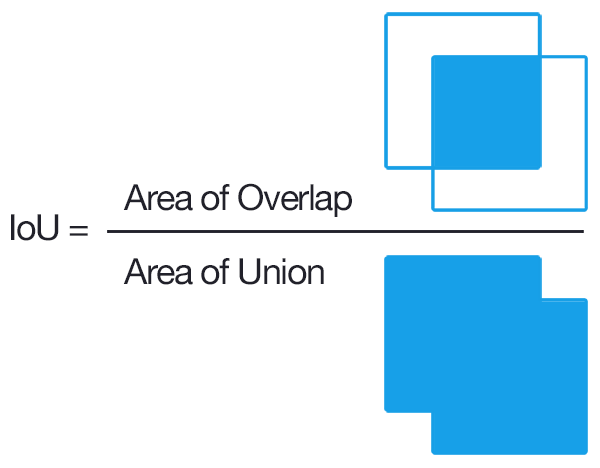


## TF add-on
* 추가 기능을 지원하기위한 add-on 설치

In [37]:
!pip install tensorflow-addons

In [38]:
use_colab = True
assert use_colab in [True, False]

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import base modules

In [40]:
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models

2.15.0


# 사용 모델 선택
* 학습 및 inference에서 사용할 모델 선택

In [41]:
is_train = True

model_name = 'ed_model'
assert model_name in ['ed_model', 'u-net']

## 데이터 수집 및 Visualize

### Download data

이 프로젝트는 [Giana Dataset](https://giana.grand-challenge.org/Dates/)을 이용하여 진행한다.

* 아래 코드를 이용해 Path를 설정한다


In [42]:
if use_colab:
    DATASET_PATH='./drive/MyDrive/Colab Notebooks/IFELL/Image_segmentation/'
else:
    DATASET_PATH='./'

### Split dataset into train data and test data
* 다운로드한 데이터셋을 분류해보자.
* 이미지를 직접 로드하는 것이 아닌 데이터의 주소 (data path)를 이용해서 train data와 test data를 분리한다.

In [43]:
dataset_dir = os.path.join(DATASET_PATH) # dataset이 있는 경로

img_dir = os.path.join(dataset_dir, "train") # ./dataset , train => ./dataset/train
label_dir = os.path.join(dataset_dir, "train_labels")

In [44]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)] # 한줄에서 어떤 함수를 동작시키는 방법
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [45]:
print(len(x_train_filenames), len(y_train_filenames))

300 300


In [46]:
print(x_train_filenames[:2])
print(y_train_filenames[:2])

['./drive/MyDrive/Colab Notebooks/IFELL/Image_segmentation/train/1.bmp', './drive/MyDrive/Colab Notebooks/IFELL/Image_segmentation/train/10.bmp']
['./drive/MyDrive/Colab Notebooks/IFELL/Image_segmentation/train_labels/1.bmp', './drive/MyDrive/Colab Notebooks/IFELL/Image_segmentation/train_labels/10.bmp']


In [47]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [48]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


### Visualize

데이터 셋에서 5장 (`display_num`)의 이미지를 살펴보자.

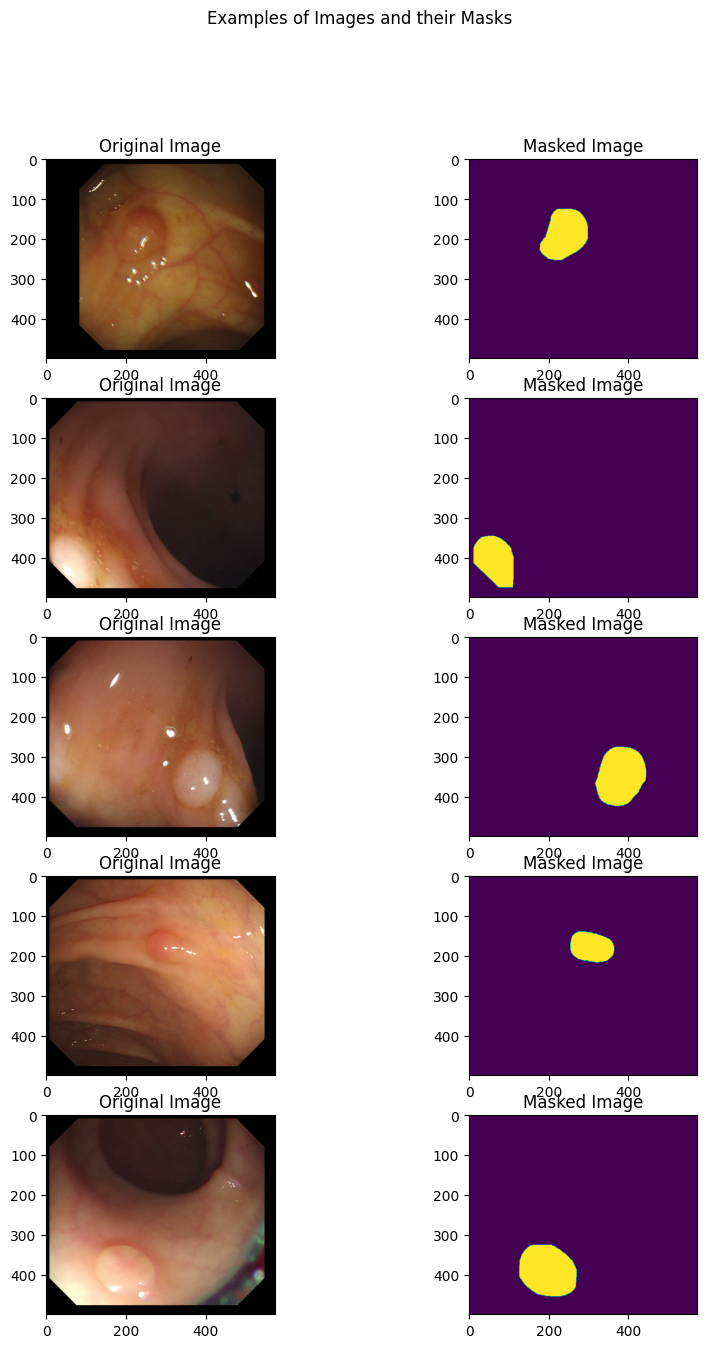

In [49]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")

plt.suptitle("Examples of Images and their Masks")
plt.show()

## Data pipeline and preprocessing 만들기

### Set up hyper-parameters

* Hyper-parameter를 셋팅해보자. 이미지 사이즈, 배치 사이즈 등 training parameter들을 셋팅해보자.
* 직접 이미지 사이즈를 조절할 수 있다.

In [51]:
# Set hyperparameters
image_size = 256
img_shape = (image_size, image_size, 3)

batch_size = 32
max_epochs = 20

if use_colab:
    checkpoint_dir ='./drive/MyDrive/train_ckpt/segmentation/exp1'
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
else:
    checkpoint_dir = './train_ckpt/segmentation/exp1'

### Build our input pipeline with `tf.data`

* tf.data.Dataset을 이용해 input pipeline을 만들어보자.
* map 함수들을 이용해 Data Augmentation을 구현해보자.


#### Our input pipeline will consist of the following steps:

* 아래 방법을 따라서 input pipeline을 만들어보자.

> 1. 이미지와 레이블 모두 파일 이름에서 파일의 바이트를 읽습니다. 라벨은 실제로 각 픽셀이 용종데이터로 (1, 0)으로 주석이 달린 이미지입니다.
> 2. 바이트를 이미지 형식으로 디코딩
> 3. 이미지 변환 적용 : (optional, input parameters에 따라서)

> * `resize`-이미지를 표준 크기로 조정합니다 (eda 또는 계산 / 메모리 제한에 의해 결정됨)
> * resize의 이유는 U-Net이 fully convolution networks 이므로 입력 크기에 의존하지 않기 때문입니다. 그러나 이미지 크기를 조정하지 않으면 가변 이미지 크기를 함께 배치 할 수 없으므로 배치 크기 1을 사용해야합니다.
> *  성능에 영향을 줄 수 있으므로 이미지 크기를 조정하여 미니 배치별로 이미지 크기를 조정하여 미니 배치별로 이미지 크기를 조정할 수도 있습니다.
> *`hue_delta`-RGB 이미지의 색조를 랜덤 팩터로 조정합니다. 이것은 실제 이미지에만 적용됩니다 (라벨 이미지가 아님). `hue_delta`는`[0, 0.5]`간격에 있어야합니다.
> *`horizontal_flip`-0.5 확률로 중심 축을 따라 이미지를 수평으로 뒤집습니다. 이 변환은 레이블과 실제 이미지 모두에 적용해야합니다.
> *`width_shift_range` 및`height_shift_range`는 이미지를 가로 또는 세로로 임의로 변환하는 범위 (전체 너비 또는 높이의 일부)입니다. 이 변환은 레이블과 실제 이미지 모두에 적용해야합니다.
> *`rescale`-이미지를 일정한 비율로 다시 조정합니다 (예 : 1/255.)
> 4. 데이터를 섞고, 데이터를 반복하여 학습합니다.

#### Why do we do these image transformations?

Data augmentation은 딥러닝을 이용한 이미지 처리분야 (classification, detection, segmentation 등) 에서 널리 쓰이는 테크닉이다.

> 데이터 증가는 여러 무작위 변환을 통해 데이터를 증가시켜 훈련 데이터의 양을 "증가"시킵니다.
> 훈련 시간 동안 우리 모델은 똑같은 그림을 두 번 볼 수 없습니다.
> Overfitting을 방지하고 모델이 처음보는 데이터에 대해 더 잘 일반화되도록 도와줍니다.

#### Processing each pathname
* 위에서 처리한 data path를 이용해 실제 이미지 데이터를 로드하는 함수이다.
* byte 형태로 데이터를 로드하고, bmp로 디코딩한다.
* 디코딩이 완료된 image를 scale과 size를 조절한다.

In [52]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3) # RGB

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=0) # BMP 0,1

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)
    # 0 ~ 255 RGB 값 ch

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    # 0 기준 초기화 -0.1 ~ 0 ~ 0.3 => 모델 가중치 초기화 범위

    return img, label_img

#### Shifting the image
* 로드한 이미지를 기반으로 이미지의 위치를 이동시키는 함수

In [53]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range: # H, W, C
            width_shift_range = tf.random.uniform([],
                                                -width_shift_range * img_shape[1],
                                                width_shift_range * img_shape[1])
        if height_shift_range:
            height_shift_range = tf.random.uniform([],
                                                -height_shift_range * img_shape[0],
                                                height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

#### Flipping the image randomly
* 로드한 이미지를 기반으로 이미지를 flip하는 함수

In [54]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))

    return tr_img, label_img

#### Assembling our transformations into our augment function
* 위에서 구현한 Augmentation 함수를 이용해 Data augmentation에 사용하는 함수를 구성한다.

In [55]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.01,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.1,  # Randomly translate the image horizontally
             height_shift_range=0.1):  # Randomly translate the image vertically
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)

    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)

    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale

    return img, label_img

In [56]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=2,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((#, #))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(# TODO, num_parallel_calls=threads)

    if is_train:
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(# TODO, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)

    return dataset

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (<ipython-input-56-5e23ef6f9bd6>, line 12)

### Set up train and test datasets
* Train dataset에서만 Data augmentation을 진행하게 설정 후 구현한다.

In [ ]:
train_dataset = get_baseline_dataset(# TODO, # 학습 데이터
                                     # TODO) # 정답 데이터
test_dataset = get_baseline_dataset(# TODO,
                                    # TODO,
                                    is_train=False)

In [ ]:
print(train_dataset)
print(test_dataset)
# dataset 나오는데 None, 256, 256 3 // None 256 256 1
#                                   None None None None
# 버전 이슈로 정답 데이터 shape이 정확히 출력되지않는 것으로 예상됩니다.

### Plot some train data
* train 데이터를 확인해보자
* data augmentation 이 적용된 이미지를 직접확인해보자.

In [ ]:
# Colab은 프로세서가 느려서 전처리에 시간이 꽤 걸립니다. 조금 기다려주세요!
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

## Build the model

해당 프로젝트는 두 개의 네트워크를 만들어보는 것이 목표이다.
* Encoder-Decoder 스타일의 네트워크

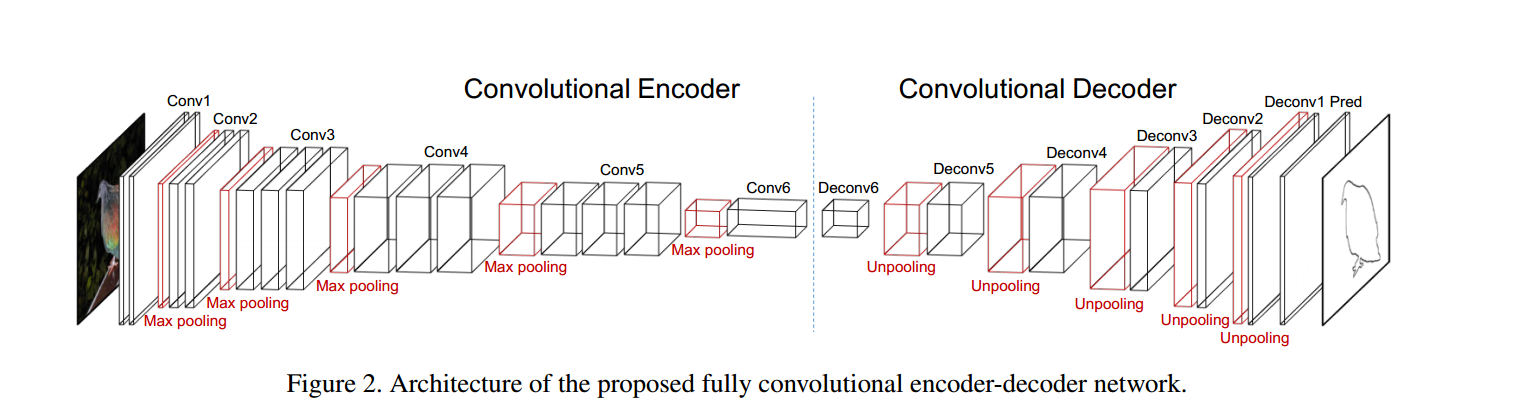


* Encoder를 이용해 우리가 가진 Train data를 작은 차원의 공간에 압축하는 방식으로 동작한다.
* Decoder는 Encoder가 압축한 데이터들을 우리가 원하는 label데이터와 같도록 재생성하는 방식으로 학습하게 된다.
    * 우리가 가진 label의 shape과 같은 형태로 데이터를 반환하게 된다.

### Encoder-Decoder architecture

#### Encoder
* 다음과 같은 구조로 Encoder로 만들어보자.
* `input data`의 shape이 다음과 같이 되도록 네트워크를 구성해보자
  * inputs = [batch_size, 256, 256, 3]
  * conv1 = [batch_size, 128, 128, 32]
  * conv2 = [batch_size, 64, 64, 64]
  * conv3 = [batch_size, 32, 32, 128]
  * outputs = [batch_size, 16, 16, 256]
* Convolution - Normalization - Activation 등의 조합을 다양하게 생각해보자.
* Pooling을 쓸지 Convolution with stride=2 로 할지 잘 생각해보자.
* `tf.keras.Sequential()`을 이용하여 만들어보자.
  
#### Decoder
* Encoder의 mirror 형태로 만들어보자.
* `input data`의 shape이 다음과 같이 되도록 네트워크를 구성해보자
  * inputs = encoder의 outputs = [batch_size, 16, 16, 256]
  * conv_transpose1 = [batch_size, 32, 32, 128]
  * conv_transpose2 = [batch_size, 64, 64, 64]
  * conv_transpose3 = [batch_size, 128, 128, 32]
  * conv_transpose4 = [batch_size, 256, 256, 16]
  * outputs = [batch_size, 256, 256, 1]
* `tf.keras.Sequential()`을 이용하여 만들어보자.

In [ ]:
if model_name == 'ed_model':
    encoder = tf.keras.Sequential(name='encoder')
    # # inputs: [batch_size, 256, 256, 3]
    # # conv-batchnorm-activation-maxpool
    # Conv2D(32, 3, padding='same', strides=1 or 2)

    encoder.add() # conv1: [batch_size, 128, 128, 32]

    encoder.add() # conv2: [batch_size, 64, 64, 64]

    encoder.add() # conv3: [batch_size, 32, 32, 128]

    encoder.add() # conv4-outputs: [batch_size, 16, 16, 256]


In [ ]:
# encoder 제대로 만들어졌는지 확인
if model_name == 'ed_model':
    bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
    print(bottleneck.shape)

In [ ]:
if model_name == 'ed_model':
    decoder = tf.keras.Sequential(name='decoder')
    # # inputs: [batch_size, 16, 16, 256]
    decoder.add() # conv_transpose1: [batch_size, 32, 32, 128]

    decoder.add() # conv_transpose2: [batch_size, 64, 64, 64]

    decoder.add() # conv_transpose3: [batch_size, 128, 128, 32]

    decoder.add() # conv transpose4 [batch_size, 256, 256, 16]

    ### output layer
    decoder.add() # conv output [batch_size, 256, 256, 1]


In [ ]:
# decoder 제대로 만들어졌는지 확인
if model_name == 'ed_model':
    predictions = decoder(bottleneck)
    print(predictions.shape)

#### Create a encoder-decocer model

In [ ]:
if model_name == 'ed_model': # 최종 모델 구성
    ed_model = tf.keras.Sequential()
    ed_model.add(encoder)
    ed_model.add(decoder)

### U-Net architecture

<img src='https://user-images.githubusercontent.com/11681225/58005153-fd934300-7b1f-11e9-9ad8-a0e9186e751c.png' width="800">

### U-Net
* [U-Net](https://arxiv.org/abs/1505.04597)

> Q. U-Net 구조의 특징은 무엇인가요?
> * FCN 구조를 가지며, skip-connection을 이용해 더 효율적인 학습을 구현할 수 있다.

#### The `tf.keras` Functional API - Model subclassing

* U-Net은 Encoder-Decoder 구조와는 달리 해당 레이어의 outputs이 바로 다음 레이어의 inputs이 되지 않는다. 이럴때는 `tf.keras.Sequential()`을 쓸 수가 없다.

* Sequential 구조가 아닌 네트워크를 만들 때 쓸 수 있는 API 가 바로 `tf.keras` functional API 이다.

* Model subclassing 방식은 `tf.keras.Model` 클래스를 상속하여 구현한다.

In [ ]:
if model_name == 'u-net':
    # class의 구조를 가지고 있다.
    class Conv(tf.keras.Model):
        # 재료를 준비하는 부분으로 봐주시면 됩니다.
        # self. 가 붙은게 클래스 내에서 관리하는 변수 및 함수를 의미합니다.
        def __init__(self, num_filters, kernel_size):
            # 학습되는 가중치를 가진 레이어는 반드시 iniat안에 있어야합니다.
            super(Conv, self).__init__()
            # init에 선언되는 layers는 학습가능한 파라미터가 있는 layers입니다.
            self.conv1 = layers.Conv2D(num_filters, kernel_size)# TODO
            self.bn = # TODO
            self.relu = # TODO

        # 실제 모델을 구성하는 부분입니다.
        # __init__에 레이어를 구성할 재료를 모은 후  call에서 조립 (연결)
        def call(self, inputs, training=True): # __call__
            x = # layers.Conv2D
            x = # layers.BatchNorm
            x = # ReLU

            return x

# class가 생성될때
# conv = Conv(num_filters=16, kernel_size=3) # Conv class의 __init__함수가 동작!
# conv(inputs) # Call => Conv-bn-relu

In [ ]:
if model_name == 'u-net':
    class ConvBlock(tf.keras.Model):
        def __init__(self, num_filters):
            super(ConvBlock, self).__init__()
            self.conv1 = Conv(num_filters, 3) # TODO # conv-bn-relu
            self.conv2 = # TODO # conv-bn-relu

        def call(self, inputs, training=True):
            conv_block = # TODO
            conv_block = # TODO

            return conv_block


    class EncoderBlock(tf.keras.Model):
        def __init__(self, num_filters):
            super(EncoderBlock, self).__init__()
            self.conv_block = # TODO
            self.encoder_pool = # TODO

        def call(self, inputs, training=True):
            encoder = # TODO
            encoder_pool = # TODO

            return encoder_pool, encoder


    class DecoderBlock(tf.keras.Model):
        def __init__(self, num_filters):
            super(DecoderBlock, self).__init__()
            self.convT = # TODO
            self.bn = # TODO
            self.relu = # TODO
            self.conv_block = # TODO

        def call(self, input_tensor, concat_tensor, training=True): # convT - bn - relu
            decoder = # ConvT
            decoder = # bn
            decoder = # relu
            decoder = # concat
            decoder = # conv_block

            return decoder

In [ ]:
if model_name == 'u-net':
    class UNet(tf.keras.Model):
        def __init__(self):
            super(UNet, self).__init__()
            self.encoder_block1 = # 32
            self.encoder_block2 = # 64
            self.encoder_block3 = # 128
            self.encoder_block4 = # 256

            self.center = # 512 conv block

            self.decoder_block4 = # 256
            self.decoder_block3 = # 128
            self.decoder_block2 = # 64
            self.decoder_block1 = # 32

            self.output_conv = # 1

        def call(self, inputs, training=True):
            encoder1_pool, encoder1 = # output 2개
            encoder2_pool, encoder2 = # output 2개
            encoder3_pool, encoder3 = # output 2개
            encoder4_pool, encoder4 = # output 2개

            center = #

            decoder4 = # input 2개
            decoder3 = # input 2개
            decoder2 = # input 2개
            decoder1 = # input 2개

            outputs = #

            return outputs

#### Create a U-Net model
* 위에서 구현한 Class들을 생성해 최종적으로 U-net 모델을 구현해준다.


In [ ]:
if model_name == 'u-net':
    unet_model = UNet()

### Defining custom metrics and loss functions

우리가 사용할 loss function은 다음과 같다.
* binary cross entropy
* dice_loss

* Image Segmentation Task에서 정답을 더 잘 찾아내기위해 새로운 Loss를 추가해 사용한다.
> [논문](http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf)에 나온 Dice coefficient 수식

$$D = \frac{2 \sum_{i}^{N} p_{i}g_{i}}{\sum_{i}^{N} p_{i}^{2} + \sum_{i}^{N} g_{i}^{2}}$$

> Dice loss를 추가하는 이유는 segmentation task를 더 잘 수행하기위해서이다.

> Cross-entropy loss와 Dice loss를 같이 사용해 meanIoU를 더 올리도록 학습할 수 있다.

In [ ]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [ ]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

* Dice Loss가 최대화되는 방향으로 구해지기 때문에, 아래와 같이 사용한다.
* 새로운 Loss function을 사용하기위해서 기존에 사용하였던 Binary crossentropy loss와 새로 구현한 Dice loss를 더하는 방식으로 구성한다.

In [ ]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)

    return loss

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)

### Select a model

In [ ]:
if model_name == 'ed_model':
    print('select the Encoder-Decoder model')
    model = ed_model

if model_name == 'u-net':
    print('select the U-Net model')
    model = unet_model

### Checkpoints

In [ ]:
if not tf.io.gfile.exists(checkpoint_dir):
    tf.io.gfile.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

if is_train:
    checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                   model=model)
else:
    checkpoint = tf.train.Checkpoint(model=model)

## Train your model
* 모델 학습 이전에 모델에서 예측한 이미지를 출력할 수 있는 함수를 작성해 모델 성능 테스트에 사용하자.

In [ ]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

### Training - `tf.GradientTape()` 함수 이용
* 학습을 진행하며, 위에서 구성한 Train dataset과 Test dataset등을 이용해 학습을 진행한다.
* 학습 데이터의 갯수가 부족하기때문에 Test dataset을 Validation dataset으로 사용한다.

In [ ]:
# save loss values for plot
loss_history = []
global_step = 0 # step 수 정의 (선택)

print_steps = 10 # tf.gradient_tape
save_epochs = 5 # tf.gradient_tape
################################################################################
for epoch in range(max_epochs):
    for images, labels in train_dataset: # 데이터 로드 파트 ex) data len 240 / batch 100 => 3
        start_time = time.time()
        global_step = global_step + 1

        with tf.GradientTape() as tape: # 모델 학습 파트
            # images [batch_size, 256,256,3]
            predictions = model(# TODO, training=True)
            # label [batch_size, 256, 256, 1]
            loss = bce_dice_loss(labels, # TODO)

        # 가중치 업데이트 파트
        gradients = tape.gradient(# TODO, model.trainable_variables)
        optimizer.apply_gradients(zip(# TODO, model.trainable_variables))

################################################################################
        # 학습 상태 출력
        epochs = global_step * batch_size / float(num_train_examples)
        duration = time.time() - start_time

        if global_step % print_steps == 0:
            clear_output(wait=True)
            examples_per_sec = batch_size  / float(duration)
            print("Epochs: {:.2f} global_step: {} loss: {:.3f} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                        epochs, global_step, loss, examples_per_sec, duration))

            loss_history.append([epoch, loss])

            # print sample image
            for test_images, test_labels in test_dataset.take(1):
                predictions = model(test_images, training=False)

            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[0,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[0, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[0, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

    # saving (checkpoint) the model periodically
    if (epoch+1) % save_epochs == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

### Plot the loss

In [ ]:
loss_history = np.asarray(loss_history)
plt.figure(figsize=(4, 4))
plt.plot(loss_history[:,0], loss_history[:,1])
plt.show()

## Evaluate the test dataset
* 모델을 평가해보자.

In [ ]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

* 테스트 데이터셋을 불러와서 meanIoU 값을 구해보자.


In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

#mean = tf.keras.metrics.Mean("mean_iou")
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))
#print("mean_iou: {}".format(mean.result().numpy()))

* Test Dataset 내에 데이터들을 얼만큼 잘 맞추었는지 직접 확인해보자.

In [ ]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

In [ ]:
print_images()